In [1]:
"""Temporary fix for importing modules from parent directory"""

import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pinocchio as pin
import casadi as cs
import numpy as np

In [3]:
from varitop.misc import euler_rule, qconj, q2rm, quat_prod
from varitop.integrator import DelIntegrator as DI

In [4]:
from darli.modeling.functional import Functional
from darli.backend import CasadiBackend

In [5]:
urdf_path = '../assets/urdf/skydio_x2.urdf'

In [6]:
rmodel = Functional(CasadiBackend(urdf_path))

In [7]:
nq = rmodel.nq
nv = rmodel.nv
nu = rmodel.nu

In [8]:
nq, nv, nu

(7, 6, 6)

In [9]:
K = cs.vcat(
    [
        cs.hcat([0.0, 0.0, 0.0, 0.0]),
        cs.hcat([0.0, 0.0, 0.0, 0.0]),
        cs.hcat([1.0, 1.0, 1.0, 1.0]),
        cs.hcat([-0.18, 0.18, 0.18, -0.18]),
        cs.hcat([0.14, 0.14, -0.14, -0.14]),
        cs.hcat([-0.0201, 0.0201, 0.0201, -0.0201]),
    ]
)

In [10]:
di = DI()
di.nq = nq
di.nv = nv
di.nu = 4
di.free_body = True
di.rule = euler_rule
di.lagrangian = rmodel.lagrangian

## Optimization

In [11]:
ns = 50
tf = 2
dt = tf / ns

In [12]:
def define_force():
    q = cs.SX.sym("q", di.nq)
    dq = cs.SX.sym("dq", di.nq)
    u = cs.SX.sym("u", 4)

    f = K @ u
    fr = cs.vcat([f[3:], 0])
    ft = f[:3]
    
    return cs.Function(
            "f",
            [q, dq, u],
            [cs.vcat([ft, 2 * quat_prod(q[3:], fr)])],
        )
f = define_force()

In [13]:
def define_constraint():
    q = cs.SX.sym("q", di.nq)
    dq = cs.SX.sym("dq", di.nq)
    u = cs.SX.sym("u", di.nu)

    return cs.Function("phi0", [q], [q[3:].T @ q[3:] - 1])

phi0 = define_constraint()

In [14]:
di.add_generalized_forces([f])
di.add_dynamics_constraints([phi0])

In [15]:
opti_problem = cs.Opti()
q = opti_problem.variable(ns, nq)
u = opti_problem.variable(ns - 1, 4)
lambdas = opti_problem.variable(ns - 1, 1)

In [16]:
di.get_residual()

Function(del:(q-1[7],q[7],q+1[7],dt,lambda,u[4])->(DEL Residual[8]) SXFunction)

In [17]:
del_res = di.get_residual()
for i in range(1, ns - 1):
    qres = del_res(q[i - 1, :], q[i + 0, :], q[i + 1, :],  dt, lambdas[i, :], (u[i - 1, :] + u[i, :]) / 2)
    opti_problem.subject_to(qres == 0)

In [18]:
initial_configuration = opti_problem.parameter(nq)
desired_configuration = opti_problem.parameter(nq)

In [19]:
opti_problem.subject_to(q[0, :].T == initial_configuration)
opti_problem.subject_to(q[0, :].T == q[1, :].T)
opti_problem.subject_to(q[-1, :].T == desired_configuration)
opti_problem.subject_to(q[-1, :].T == q[-2, :].T)

In [20]:
# cost
cost = 0 
# stage cost ordinary
for i in range(ns-1):
    # cost += 1e-2*cs.sumsqr(q[i,:3].T - desired_configuration[:3])*dt
    # print(((q[i + 1,:] - q[i,:])/dt).shape)
    vi = di.v(q[i + 1, :], (q[i + 1,:] - q[i,:]).T/dt)
    cost += 1e-2*cs.sumsqr(vi[:3]) * dt
    cost += 1e+3* cs.sumsqr(vi[3:]) * dt
    # v = (q[i+1,:3] - q[i,:3])/dt
    # w = quat_prod(qconj(q[i,3:]), q[i,3:])
    # cost += 5e-2*cs.sumsqr(v)*dt
    # cost += 5e-2*cs.sumsqr(w)*dt

    cost += 0.005*cs.sumsqr(u[i,:])*dt

# separate velocities stage cost 
# for i in range(ns-1):
#     v = (q[i+1,:3] - q[i,:3])/dt
#     w = quat_prod(qconj(q[i,3:]), q[i,3:])

#     cost += 1e-2*cs.sumsqr(q[i,:])*dt
#     cost += 5e-2*cs.sumsqr(v)*dt
#     cost += 5e-2*cs.sumsqr(w)*dt
#     cost += 0.005*cs.sumsqr(u[i,:])*dt
    
# # Terminal cost 
# cost += 5e-2*cs.sumsqr(q[-1,:3].T - desired_configuration[:3])
# cost += 10e-2*cs.sumsqr(di.v(q[-1, :], (q[-1,:] - q[-2,:]).T/dt))


In [21]:
# Limits 
# joint limits 
# opti_problem.subject_to(opti_problem.bounded(rmodel.q_min, q.T, rmodel.q_max))
# velocity limits
# v_max = 100
# v_lims = np.full((3), v_max)
# w_max = 100
# w_lims = np.full((4), w_max)
# for i in range(ns-1):
#     v = (q[i+1,:3] - q[i,:3])/dt
#     w = quat_prod(qconj(q[i,3:]), q[i,3:])
#     opti_problem.subject_to(opti_problem.bounded(-v_max, v.T, v_max))
#     opti_problem.subject_to(opti_problem.bounded(-w_max, w.T, w_max))
# # torque limits
# u_max = 1000
# u_lims = np.full((4), u_max) 
# opti_problem.subject_to(opti_problem.bounded(0, u.T,  u_max))

In [22]:
np.cos(np.pi / 4)

0.7071067811865476

In [23]:
opti_problem.set_value(initial_configuration,np.array([0, 0, 0, 0, 0, 0, 1]))
opti_problem.set_value(desired_configuration,np.array([1, 1, 1, 0, 0, 0, 1]))

In [24]:
opti_problem.minimize(cost)
# opti_problem.solver('sqpmethod')
opti_problem.solver('ipopt')

In [25]:
sol = opti_problem.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.15, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     8538
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6065

Total number of variables............................:      595
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      412
Total number of inequality c

In [26]:
q_opt = opti_problem.value(q)
u_opt = opti_problem.value(u)

In [27]:
basis_vectors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
rms = np.array([pin.XYZQUATToSE3(qi).rotation for qi in q_opt])
pos = np.array([pin.XYZQUATToSE3(qi).translation for qi in q_opt])

In [28]:
import matplotlib.pyplot as plt

# Extract the x, y, z components of the basis vectors
x = rms[:, 0]
y = rms[:, 1]
z = rms[:, 2]

# Create three separate plots for x, y, z components
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3))

# Plot x component
ax1.plot(x)
ax1.set_xlabel("Frame")
ax1.set_ylabel("x component")

# Plot y component
ax2.plot(y)
ax2.set_xlabel("Frame")
ax2.set_ylabel("y component")

# Plot z component
ax3.plot(z)
ax3.set_xlabel("Frame")
ax3.set_ylabel("z component")

# Display the plots
plt.tight_layout()
plt.show()

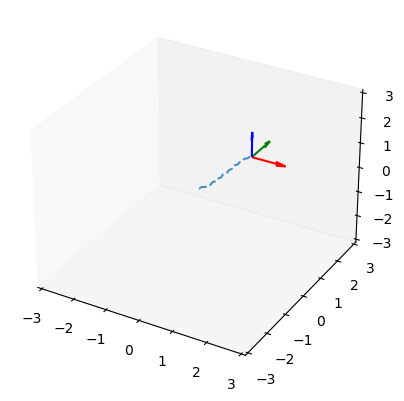

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)

ax.grid(False)

ax.plot(pos[:, 0], pos[:, 1], pos[:, 2], ls='--', alpha=0.8)

basis = ax.quiver(pos[0, 0], pos[0, 1], pos[0, 2], basis_vectors[0], basis_vectors[1], basis_vectors[2])


def update(frame):
    # Rotate the basis vectors
    rotated_vectors = rms[frame] @ basis_vectors.T

    global basis
    basis.remove()
    basis = ax.quiver(
        pos[frame, 0], pos[frame, 1], pos[frame, 2], rotated_vectors[0], rotated_vectors[1], rotated_vectors[2]
    ,color=['red', 'green', 'blue'])


# Create the animation
animation = FuncAnimation(fig, update, frames=len(q_opt), interval=tf * 1000 / ns)

# Save the animation as a GIF using Pillow writer
animation.save("evolution_history_x2.gif")

# Display the animation
plt.show()

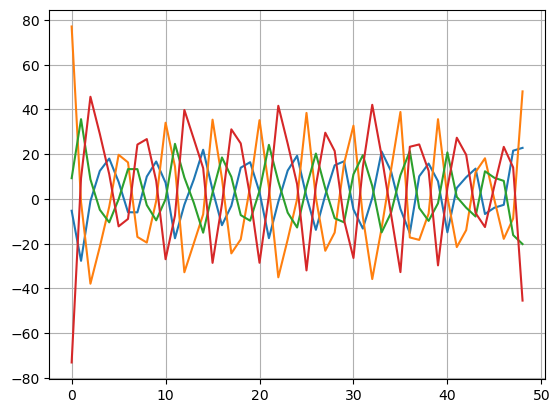

In [ ]:
plt.plot(u_opt)
plt.grid()
plt.show()

In [ ]:
q_opt[0, 3:].T @ q_opt[0, 3:]

1.0000000000032778

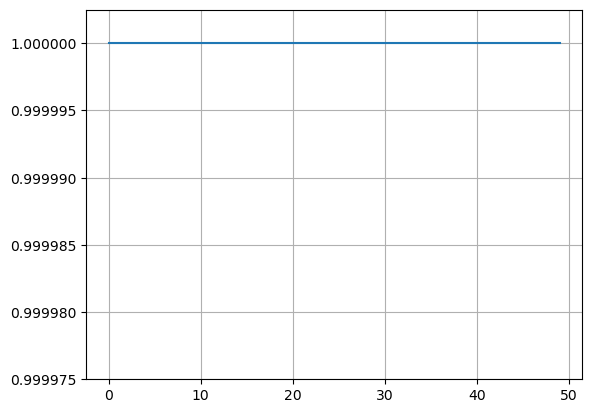

In [ ]:
plt.gca().ticklabel_format(style='plain', useOffset=False)
plt.plot(np.array(
    [qi[3:].T @ qi[3:] for qi in q_opt]
))
eps = 1e-4 / 4
plt.ylim([1 - eps, 1 + eps / 10])
plt.grid()
plt.show()